# Graph Anomaly Detection


## Loading and preparing the data

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle as pkl

In [2]:
# Read files
path = "./dades_marti/"
df_classes = pd.read_csv(path + "elliptic_txs_classes.csv") # Nodes' labels
df_edges = pd.read_csv(path + "elliptic_txs_edgelist.csv") # Edges
df_features = pd.read_csv(path + "elliptic_txs_features.csv", header=None) # Nodes' features

In [3]:
# Change column names of df_features
colNames1 = {'0': 'txId', 1: "Time Step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

df_features = df_features.rename(columns=colNames)

In [4]:
# Pass unknown to number -1, 1 ilicit, 0 licit
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = -1
df_classes.loc[df_classes['class'] == '2', 'class'] = 0
df_classes.loc[df_classes['class'] == '1', 'class'] = 1

# Time step now starts at 0
df_features['Time Step'] -= 1

print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edges.shape)
print('Shape of features', df_features.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


In [5]:
# Merge Class and features
df_class_feature = pd.merge(df_classes, df_features)
# df_class_feature.head()
df = df_class_feature
del df_class_feature
df.head()

,txId,class,Time Step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,-1,0,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,-1,0,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,-1,0,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,0,0,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,-1,0,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


## Single out a time step and work with

#### Study timestep properties

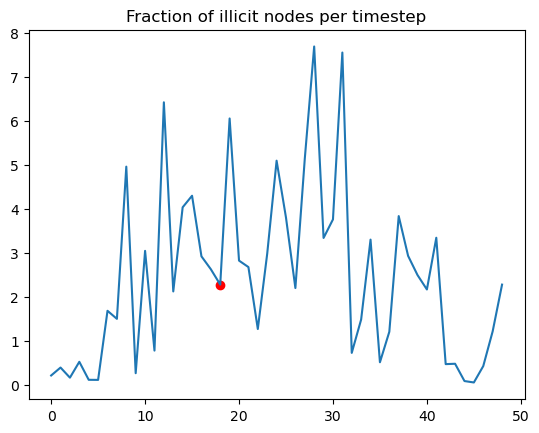

Median proportion highlighted in red


In [6]:
# Illicit node proportion

proportions = []
for i in range(0, 49):
    class_vector = df[df['Time Step'] == i]['class']
    illicit_count = len([classe for classe in class_vector if classe == 1])
    proportions.append(100*illicit_count / len(class_vector))

# Get the index of the median
median_index = np.argsort(proportions)[len(proportions)//2]

# Plot the proportions of illicit nodes
plt.plot(proportions)
plt.scatter(median_index, proportions[median_index], color='red')
plt.title('Fraction of illicit nodes per timestep')
plt.show()

print('Median proportion highlighted in red')

#### Study timestep 18

I picked 18 because it's the median proportion but it's pretty arbitrary; it doesn't matter.

In [7]:
# Separate this timestep's rows from the df's
df18 = df[df['Time Step'] == 18]
df18_edges = df_edges[df_edges['txId1'].isin(df18['txId']) & df_edges['txId2'].isin(df18['txId'])]

# Version of the df for machine learning
df18_ml = df18.drop(columns=['txId', 'class', 'Time Step'])

len(df18), len(df18_edges)

(3506, 3838)

In [8]:
# Create graph from the df of edges
edgelist = [(r['txId1'], r['txId2']) for i, r in df18_edges.iterrows()]
G18 = nx.Graph(edgelist)

G18.order(), G18.size()

(3506, 3838)

In [9]:
# Data
print("Nº of illicit nodes:", len(df18[df18['class'] == 1]))
print("Nº of licit nodes:", len(df18[df18['class'] == 0]))
print("Nº of unknown nodes:", len(df18[df18['class'] == -1]))

Nº of illicit nodes: 80
Nº of licit nodes: 665
Nº of unknown nodes: 2761


#### Node2Vec

In [10]:
# node2vec embeddings?
from node2vec import Node2Vec
import tqdm as notebook_tqdm
from gensim.models import Word2Vec

train = False
if train:
    node2vec = Node2Vec(G18, dimensions=5, walk_length=30, num_walks=200, p=2, q=1, workers=1)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    model.save("./dades_marti/node2vec_ts18.bin")

In [11]:
model = Word2Vec.load('dades_marti/node2vec_ts18.bin')

# Access the embedding weights
embeddings = model.wv.vectors

# Check the shape of the embedding matrix
print("Shape of embedding matrix:", embeddings.shape)

Shape of embedding matrix: (3506, 5)


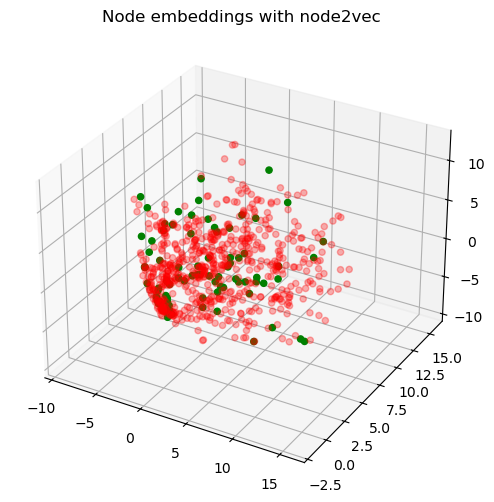

In [12]:
# Plot 3D embeddings

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

# Color code by classes
colours = ['yellow', 'red', 'green']
alphas = [0, 0.3, 1]

for label in np.unique(df18['class']):
    indices = np.where(df18['class'] == label)
    ax.scatter(embeddings[indices, 0],
               embeddings[indices, 1],
               embeddings[indices, 2],
               c=colours[label+1],
               label=f'Class {label}',
               alpha=alphas[label+1])
    
plt.title("Node embeddings with node2vec")
plt.show()

# Una altra opcio es tsne, per reduir dimensionalitat i plotejar


Now we try to do machine learning with these embeddings to see if we're able to obtain similar results than with the initial features


Explained variance ratio: 0.9994220613459973
Data reduction, from shape (3506, 167) to (3506, 100)

Training Random forest...

Testing Random forest...

Accuracy: 98.00%
Precision: 100.00%
Recall: 83.00%
F1 Score: 91.00%


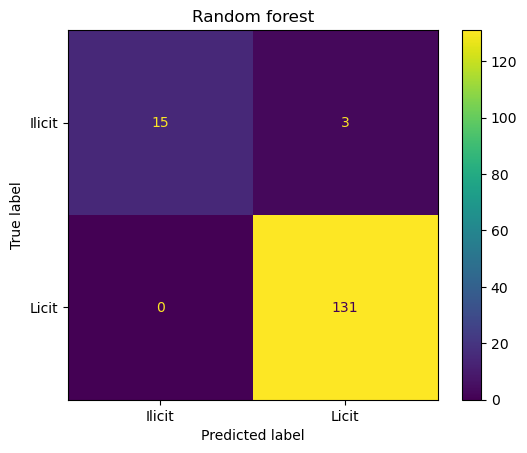

In [13]:
from mLearning import machineLearning

method = "Random forest"

# First, with the original dataframe
df_training = machineLearning(df18)
applied_PCA = df_training.apply_PCA(ncomponents=100)
df_training.train_and_test(method, display_conf_matrix=True, modeMarti=True)


Training Random forest...

Testing Random forest...

Accuracy: 87.00%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%


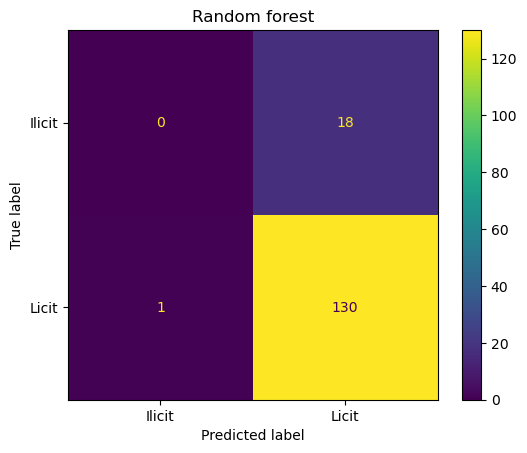

In [14]:
# Then, with a node2vec dataframe

# Create a DataFrame for the principal components
columns = [f"n2v_{i+1}" for i in range(embeddings.shape[1])]
n2v_df = pd.DataFrame(data=embeddings, columns=columns)

n2v_df['class'] = list(df18['class'])
n2v_df['txId'] = list(df18['txId'])

df_training = machineLearning(n2v_df)
df_training.train_and_test(method, use_pca=False, display_conf_matrix=True, modeMarti=True)


Compared to the performance of the classifier with the original features, we can see that the node2vec embeddings with only 5 dimensions are not useful. We will try if for some number of dimensions we can get better results.

In [15]:
# For up to 128 (2^7) embedding dimensions
train_this = False
if train_this:
    results = {}
    for i in range(2, 8):
        print(f"\nIteration {i-1}, trying embeddings of {2**i} dimensions")
        emb_dim = 2**i
        # Node2Vec training
        node2vec = Node2Vec(G18, dimensions=emb_dim, walk_length=30, num_walks=200, p=2, q=1, workers=1)
        model = node2vec.fit(window=10, min_count=1, batch_words=4)
        model.save(f"./dades_marti/ts18_n2v_{emb_dim}.bin")

        # Create the dataset
        embeddings = model.wv.vectors
        columns = [f"n2v_{i+1}" for i in range(embeddings.shape[1])]
        n2v_df = pd.DataFrame(data=embeddings, columns=columns)
        # Add pertinent vectors
        n2v_df['class'] = list(df18['class'])
        n2v_df['txId'] = list(df18['txId'])
        
        df_training = machineLearning(n2v_df)
        df_training.train_and_test(method, use_pca=False, display_conf_matrix=True, modeMarti=True)
        # Aim for a good f1 score and set >0.75 as a boundary
        this_iterations_results = df_training.get_results()
        this_iterations_results = list(this_iterations_results.iloc[-1])
        results[2**i] = this_iterations_results
        if results[2**i][-1] >= 0.75:
            break 


In [16]:
a = {'a': [0,1,2,3,4,5,6], 'b':[6,5,4,3,2,1,0]}
# a = pd.DataFrame(a)
a['a'][-1]

6

#### Cluster-then-label

In [17]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *

import random
from collections import Counter
from icecream import ic

In [18]:
# Cluster-then label?

X_train, X_test, y_train, y_test = train_test_split(df18_ml, df18['class'])

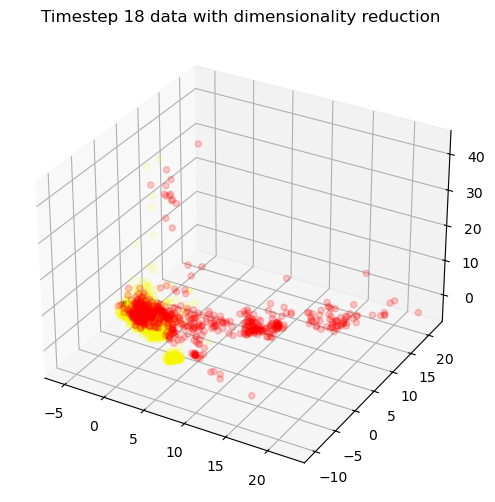

In [19]:
# Standarize features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df18_ml)

# Apply PCA
pca = PCA(n_components=80)  # You can choose the number of components you want to keep
principal_components = pca.fit_transform(scaled_data)

# Visualize

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

# Color code by classes
colours = ['yellow', 'red', 'green']
alphas = [0.1, 0.2, 1]

for label in np.unique(df18['class']):
    indices = np.where(df18['class'] == label)
    ax.scatter(principal_components[indices, 0],
               principal_components[indices, 1],
               principal_components[indices, 2],
               c=colours[label+1],
               label=f'Class {label}',
               alpha=alphas[label+1])
    
plt.title("Timestep 18 data with dimensionality reduction")
plt.show() 


Run KMeans with 32 clusters.


c:\Users\marti\anaconda3\envs\graphanomaly\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\marti\anaconda3\envs\graphanomaly\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


Run KMeans with 32 clusters.
Run KMeans with 32 clusters.
Run KMeans with 32 clusters.
Run KMeans with 32 clusters.
Run KMeans with 32 clusters.
Run KMeans with 32 clusters.
Run KMeans with 32 clusters.
Run KMeans with 32 clusters.
Run KMeans with 32 clusters.
After 10 iterations:
- 300 nodes were pseudo-labelled as 0.
- 13 node(s) were pseudo labelled as 1.



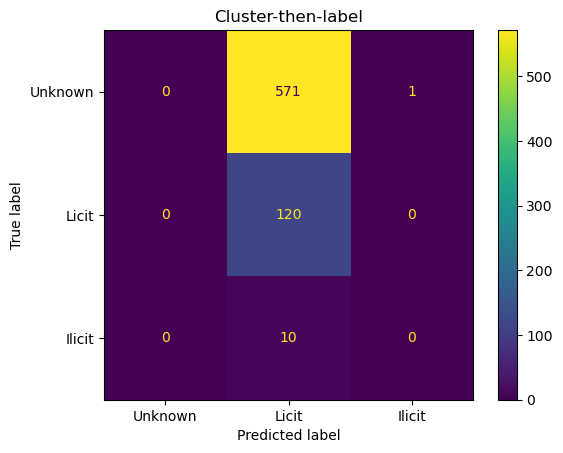

Recall: 0.0
F1 score: 0.0


In [20]:
from cluster_label import Cluster_Then_Label

ctl = Cluster_Then_Label(df18_ml, df18['class'], n_clusters=32, method='kmeans', random_state=None)
ctl.loop(n_iters=10)
ctl.test(display_conf_matrix=True)

We plot epsilon values to know what is the optimal eps parameter for DBSCAN

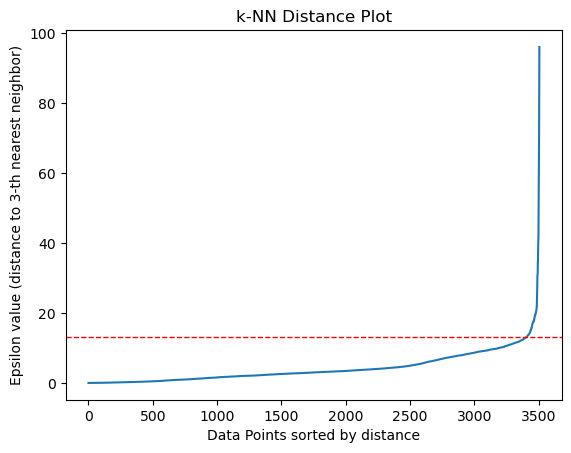

In [21]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Sample data
X = df18_ml

# Compute k-nearest neighbors (k = minPts)
minPts = 3
neighbors = NearestNeighbors(n_neighbors=minPts)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort distances and plot
distances = np.sort(distances[:, minPts - 1], axis=0)
plt.plot(distances)
plt.axhline(y=13, color='r', linestyle='--', linewidth=1, label='y=13')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon value (distance to {}-th nearest neighbor)'.format(minPts))
plt.title('k-NN Distance Plot')
plt.show()


After 10 iterations:
- 80 nodes were pseudo-labelled as 0.
- 10 node(s) were pseudo labelled as 1.



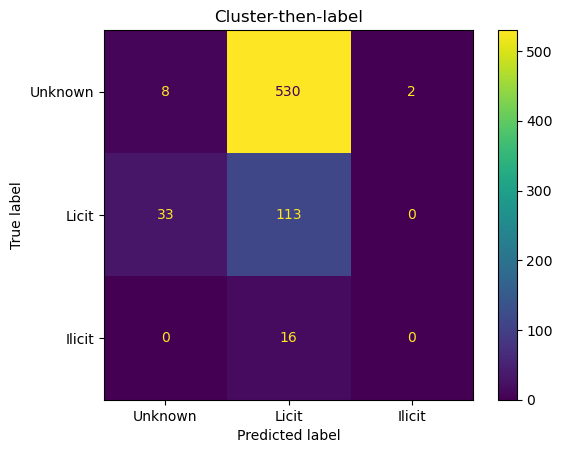

Recall: 0.0
F1 score: 0.0


In [23]:
from cluster_label import Cluster_Then_Label

ctl = Cluster_Then_Label(df18_ml, df18['class'], n_clusters=32, method='dbscan', random_state=2003)
ctl.loop(n_iters=10)
ctl.test(display_conf_matrix=True)

